In [2]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from code.utils.utils import get_int_from_
from code.utils.settings import DefaultPath

Ora ho i risultati di JOSIE-top3 in formato csv 'set_id,s1,o1,s2,o2,s3,o3', voglio andare a ottenere un qualcosa del tipo 'l_id,r_id,o' e raggruppare le coppie così ottenute per l'overlap, con intervali tipo [1,10), [10,50),[50,100)... e poi su questi intervalli vedo quali coppie hanno il corrispetivo nei risultati di SLOTH.

Su queste coppie poi si possono fare meglio delle considerazioni sulla similarità data dagli embedding anche, perché è rimosso (?) il bias della Jaccard similarity.

In [3]:
n = 45673

In [4]:
id_table_file = DefaultPath.josie_stuff_path.base + f'josie-test-{n}/id_table.csv'
id_conversion_table = pl.read_csv(id_table_file)
sloth_results = pl.scan_csv(DefaultPath.data_path.wikitables + 'threshold-r5-c2-a50/sloth-results-r5-c2-a50.csv')

josie_ids, sloth_ids = list(id_conversion_table.to_dict(as_series=False).values())
id_conversion_table = None

In [5]:
converter = {j: s for j, s in zip(josie_ids, sloth_ids)}

In [6]:
josie_results = pl.scan_csv(DefaultPath.josie_stuff_path.base + f'josie-test-{n}/result_k_5.csv')
pairs = pl.LazyFrame(schema=['r_id', 's_id', 'overlap'])

In [7]:
def split_numbers(s):
    nums = get_int_from_(s)
    return nums[::2], nums[1::2]    # set IDs, overlaps

In [8]:
josie_results = josie_results \
    .select(['query_id', 'results']) \
        .with_columns(
            pl.col('results') \
                .map_elements(split_numbers, pl.List(pl.List(pl.Int64)))
            ) \
                .with_columns(pl.col('results').list.to_struct()) \
                    .unnest('results') \
                        .explode('field_0', 'field_1') \
                            .collect()
josie_results    

query_id,field_0,field_1
i64,i64,i64
742,1507,20
742,43040,20
742,743,19
742,13931,13
742,15955,13
…,…,…
2127,27613,2
2127,2124,2
2127,27604,2


In [8]:
with open(DefaultPath.josie_stuff_path.base + 'josie-test-45673/sloth_tables.set') as f:
    lines = f.readlines()

In [9]:
row_idx = 101
row = josie_results[row_idx]
row

query_id,field_0,field_1
i64,i64,i64
34258,43086,22


In [10]:
len(set(lines[row['query_id'][0]].split(',')[:]).intersection(
    lines[row['field_0'][0]].split(',')[:]
))

21

In [10]:
josie_results = josie_results \
    .drop_nulls() \
        .map_rows(lambda t: (converter[t[0]], converter[t[1]], t[2]))
josie_results.columns = ['r_id', 's_id', 'overlap']
josie_results

r_id,s_id,overlap
str,str,i64
"""24216428-1""","""9996355-1""",20
"""24216428-1""","""10147788-1""",20
"""24216428-1""","""24216428-2""",19
"""24216428-1""","""34021837-1""",13
"""24216428-1""","""35235464-1""",13
…,…,…
"""22194385-2""","""16565484-4""",2
"""22194385-2""","""22194359-1""",2
"""22194385-2""","""16565439-5""",2


In [14]:
import jsonlines

from code.utils.utils import rebuild_table

tables = {}
with jsonlines.open(DefaultPath.data_path.wikitables + 'threshold-r5-c2-a50/sloth-tables-r5-c2-a50.jsonl') as f:
    for jtable in f:
        tables[jtable['_id']] = rebuild_table(jtable, mode='polars.lazy')

In [26]:
row_idx = 455
row = josie_results[row_idx]
tr, ts = tables[row['r_id'][0]].collect(), tables[row['s_id'][0]].collect()
tr

#,Stadium,Capacity,Location,Region,Home Team,Opened
str,str,str,str,str,str,str
"""1""","""Stadio Giusepp…","""80,074""","""Milan""","""Lombardy""","""AC Milan , Int…","""1927"""
"""2""","""Stadio Olimpic…","""72,700""","""Rome""","""Lazio""","""Roma , Lazio a…","""1952"""
"""3""","""Stadio San Pao…","""60,240""","""Naples""","""Campania""","""Napoli""","""1959"""
"""4""","""Stadio San Nic…","""58,248""","""Bari""","""Apulia""","""Bari""","""1990"""
"""5""","""Stadio Artemio…","""47,282""","""Florence""","""Tuscany""","""Fiorentina""","""1931"""
…,…,…,…,…,…,…
"""49""","""Stadio Città d…","""13,128""","""Arezzo""","""Tuscany""","""Arezzo""","""1961"""
"""50""","""Stadio Romeo M…","""12,500""","""Vicenza""","""Veneto""","""Vicenza""","""1934"""
"""51""","""Stadio Simonet…","""12,000""","""Cava de' Tirre…","""Campania""","""Cavese""","""1960"""


In [27]:
ts

Club,City,Stadium,Capacity,2006-2007 season
str,str,str,str,str
"""Atalanta""","""Bergamo""","""Stadio Atleti …","""26,378""","""8th in Serie A…"
"""Cagliari""","""Cagliari""","""Stadio Sant'El…","""23,486""","""16th in Serie …"
"""Catania""","""Catania""","""Stadio Angelo …","""23,420""","""13th in Serie …"
"""Empoli""","""Empoli""","""Stadio Carlo C…","""19,795""","""7th in Serie A…"
"""Fiorentina""","""Florence""","""Stadio Artemio…","""47,282""","""6th in Serie A…"
…,…,…,…,…
"""Roma""","""Rome""","""Stadio Olimpic…","""82,307""","""2nd in Serie A…"
"""Sampdoria""","""Genoa""","""Stadio Luigi F…","""36,685""","""9th in Serie A…"
"""Siena""","""Siena""","""Stadio Artemio…","""15,373""","""15th in Serie …"


In [28]:
row

r_id,s_id,overlap
str,str,i64
"""982732-2""","""11150459-1""",36


In [17]:
final_results = josie_results.lazy().join(sloth_results, on=['r_id', 's_id']).collect().sort('overlap')
final_results

r_id,s_id,overlap,jsim,o_a,a%
str,str,i64,f64,i64,f64
"""10501049-1""","""9545535-2""",1,0.292135,48,0.470588
"""10952624-14""","""10952624-16""",1,0.8,64,0.888889
"""32881111-4""","""36688363-3""",1,0.425,8,0.148148
"""40591130-1""","""40599144-1""",2,1.0,105,1.0
"""40599144-1""","""40599147-1""",2,1.0,105,1.0
…,…,…,…,…,…
"""16517223-1""","""16519520-1""",840,0.915589,1640,0.622627
"""14183983-1""","""20167926-1""",869,0.785369,1428,0.534831
"""12158330-1""","""3341919-1""",951,0.965971,3036,0.932432


In [18]:
steps = [range(1, 5), range(5, 10), range(10, 20), range(20, 50), range(50, 100), range(100, 200), range(200, 500), range(500, 5000)]

In [19]:
def mapper(t):
    for s in steps:
        if t in s:
            return f'[{s.start},{s.stop if s.stop != 5000 else "inf"})'
        
col = final_results.columns
final_results = final_results.map_rows(
    lambda t: (t[0], t[1], mapper(t[2]), t[3], t[4], t[5])
)
final_results.columns = col
final_results

r_id,s_id,overlap,jsim,o_a,a%
str,str,str,f64,i64,f64
"""10501049-1""","""9545535-2""","""[1,5)""",0.292135,48,0.470588
"""10952624-14""","""10952624-16""","""[1,5)""",0.8,64,0.888889
"""32881111-4""","""36688363-3""","""[1,5)""",0.425,8,0.148148
"""40591130-1""","""40599144-1""","""[1,5)""",1.0,105,1.0
"""40599144-1""","""40599147-1""","""[1,5)""",1.0,105,1.0
…,…,…,…,…,…
"""16517223-1""","""16519520-1""","""[500,inf)""",0.915589,1640,0.622627
"""14183983-1""","""20167926-1""","""[500,inf)""",0.785369,1428,0.534831
"""12158330-1""","""3341919-1""","""[500,inf)""",0.965971,3036,0.932432


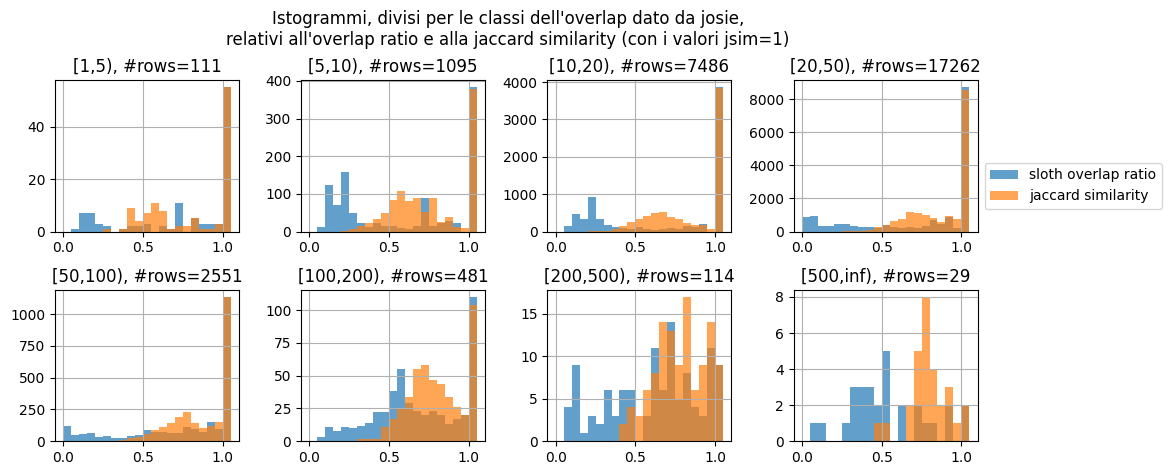

In [21]:
ncol = len(steps) // 2
fig, axes = plt.subplots(2, ncol, figsize=(10, 5))
fig.tight_layout(h_pad=3)
fig.subplots_adjust(top=0.8)
fig.suptitle('Istogrammi, divisi per le classi dell\'overlap dato da josie,\nrelativi all\'overlap ratio e alla jaccard similarity (con i valori jsim=1)', y=0.94)
for i in range(2):
    for j in range(ncol):
        r = steps[i * ncol + j]
        ax = axes[i][j]
        tag = f'[{r.start},{r.stop})' if r.stop != 5000 else f'[{r.start},inf)'
        rows = final_results.filter(pl.col('overlap') == tag)
        title = f'{tag}, #rows={rows.shape[0]}'

        ax.set_title(title)
        ax.hist(rows['a%'],     bins=np.arange(0, 1.1, 0.05), align='mid', alpha=0.7, label='sloth overlap ratio')
        ax.hist(rows['jsim'],   bins=np.arange(0, 1.1, 0.05), align='mid', alpha=0.7, label='jaccard similarity')
        ax.grid(True)
axes[0][3].legend(bbox_to_anchor=(1, 0.5))

plt.show()

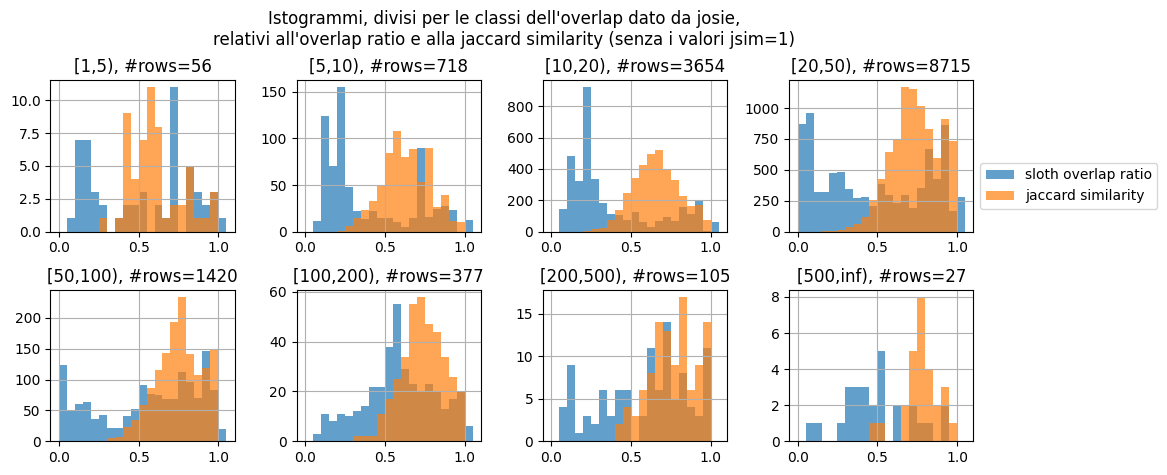

In [22]:
ncol = len(steps) // 2
fig, axes = plt.subplots(2, ncol, figsize=(10, 5))
fig.tight_layout(h_pad=3)
fig.subplots_adjust(top=0.8)
fig.suptitle('Istogrammi, divisi per le classi dell\'overlap dato da josie,\nrelativi all\'overlap ratio e alla jaccard similarity (senza i valori jsim=1)', y=0.94)
for i in range(2):
    for j in range(ncol):
        r = steps[i * ncol + j]
        ax = axes[i][j]
        tag = f'[{r.start},{r.stop})' if r.stop != 5000 else f'[{r.start},inf)'
        rows = final_results.filter((pl.col('overlap') == tag) & (pl.col('jsim') != 1))        
        title = f'{tag}, #rows={rows.shape[0]}'

        ax.set_title(title)
        ax.hist(rows['a%'],     bins=np.arange(0, 1.1, 0.05), align='mid', alpha=0.7, label='sloth overlap ratio')
        ax.hist(rows['jsim'],   bins=np.arange(0, 1.1, 0.05), align='mid', alpha=0.7, label='jaccard similarity')
        ax.grid(True)
axes[0][3].legend(bbox_to_anchor=(1, 0.5))

plt.show()

In [23]:
for tag in steps:
    tag = f'[{tag.start},{tag.stop if tag.stop != 1000 else "inf"})'
    rows = final_results.filter((pl.col('overlap') == tag))
    rows.sort(by=['a%', 'jsim', 'o_a', 'overlap'], descending=True).write_csv(f'partitions/res_jsim_{tag}.csv')